# FIAbility fake news classification

## Cloning Git repo via SSH

In [ ]:
!mkdir /root/.ssh
!touch /root/.ssh/id_ed25519
!echo "$FIABILITY_BACK_GITLAB_DEPLOY_KEY_SSH_KEY" >> /root/.ssh/id_ed25519

mkdir: cannot create directory ‘/root/.ssh’: File exists


In [ ]:
!chmod 600 /root/.ssh/id_ed25519

In [ ]:
!ssh-keyscan gitlab.com >> /root/.ssh/known_hosts

# gitlab.com:22 SSH-2.0-OpenSSH_7.9p1 Debian-10+deb10u2
# gitlab.com:22 SSH-2.0-OpenSSH_7.9p1 Debian-10+deb10u2
# gitlab.com:22 SSH-2.0-OpenSSH_7.9p1 Debian-10+deb10u2


In [ ]:
# Removing folders as they won't be overwritten by the following recursive copy 
!rm -rf .git ai db entities images repositories routes services tests

rm: cannot remove 'ai/dataset': Directory not empty


In [ ]:
!ssh-add /root/.ssh/id_ed25519 & git clone git@gitlab.com:tang.hugo1999/fiability-back.git | ssh-agent

SSH_AUTH_SOCK=/tmp/ssh-VoyakMBuNiHL/agent.393; export SSH_AUTH_SOCK;
SSH_AGENT_PID=394; export SSH_AGENT_PID;
echo Agent pid 394;
Could not open a connection to your authentication agent.
Cloning into 'fiability-back'...

remote: Enumerating objects: 2798, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 2798 (delta 32), reused 68 (delta 23), pack-reused 2718
Receiving objects: 100% (2798/2798), 221.19 MiB | 11.46 MiB/s, done.
Resolving deltas: 100% (954/954), done.
Checking out files: 100% (50/50), done.


In [ ]:
# Will overwrite existing files (but not folders, so we deleted them in advance before)
!cp -rT fiability-back/ ./

In [ ]:
!rm -rf ./fiability-back/

In [ ]:
!git config user.name "Wiem-Chouchane"

In [ ]:
!git config user.email "wiem.chouchane@efrei.net"

In [ ]:
!git status

Refresh index: 100% (50/50), done.
On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.deepnote/
	ai/dataset/.nfs000000000000005300000001
	fiability_checker.ipynb

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
!git checkout dev

Checking out files: 100% (11/11), done.
Branch 'feature/model-training-scheduler' set up to track remote branch 'feature/model-training-scheduler' from 'origin'.
Switched to a new branch 'feature/model-training-scheduler'


In [ ]:
!git status

On branch feature/model-training-scheduler
Your branch is up to date with 'origin/feature/model-training-scheduler'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.deepnote/
	ai/dataset/.nfs000000000000005300000001
	fiability_checker.ipynb

nothing added to commit but untracked files present (use "git add" to track)


# Clean & Save Data

In [ ]:
## This file has all imports and helper functions used throughout the notebook
%run ai/python_helper.py
%matplotlib inline

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Inspecting the data files, we noticed several issues for processing the traning dataset correctly. Using Regular Expression, we convert all commas between quotations to a pipe, so the CSV parsing works correctly with all values in their correct columns.

In [ ]:
input_str = open('ai/dataset/fiability_train.csv', encoding= 'utf-8')

# Remove all new lines
noNewLines = re.sub('\n', '', input_str.read())

# re-add new line at end of each row
noNewLines = re.sub('X1,X2', 'X1,X2\n', noNewLines)
  

noNewLines = re.sub(',FAKE[,]+', ',FAKE,,\n', noNewLines)
  
noNewLines = re.sub(',REAL[,]+', ',REAL,,\n', noNewLines)
  

# Replace any commas between two quotes with |
lines = noNewLines.split('\n')

def removeComma(g):
      t = g.groups()
      t = [t[0], t[1].replace(',', ' |'), t[2], t[3]]
      return "".join(t)

betweenQuotes = lambda line: re.sub(r'(.*,")(.*)(",)(.*)', lambda x: removeComma(x), line)

secondCol = lambda line: re.sub(r'^([0-9]+,)(.*,.*)(,\")(.*)$', lambda x: removeComma(x), line, 1)


lines = [betweenQuotes(l) for l in lines]
lines = [secondCol(l) for l in lines]

finalString = '\n'.join(lines)

### Save cleaned file

In [ ]:
file = open('ai/dataset/fiability_train_cleaned.csv', 'w',encoding= 'utf-8')
file.write(finalString)
file.close()

# Data Preparation

In [ ]:
train = pd.read_csv('ai/dataset/fiability_train_cleaned.csv')
test = pd.read_csv('ai/dataset/fiability_test.csv')

In [ ]:
len(train)

3997

In [ ]:
len(test)

2321

In [ ]:
train.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,NaN,NaN


In [ ]:
train = train.drop(['X1', 'X2'], axis=1)

We study if the dataset is unbalanced. From the plot we see this is not the case, as there is a similar amount of Fake and Real news articles. No further actions have to be taken.

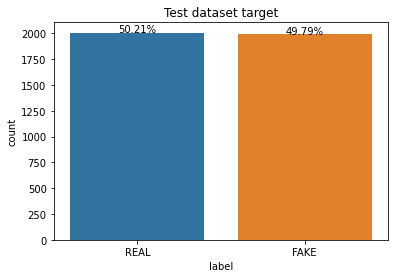

In [ ]:
from collections import Counter
ax = sns.countplot(train.label, order=[x for x, count in sorted(Counter(train.label).items(), key=lambda x: -x[1])])


for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(train)*100),
            ha='center') 
ax.set_title('Test dataset target')
show()

In [ ]:
test.head()

,ID,title,text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...


In order to not do double work by doing operations on our train and testset and to analyze general distributions of our data, we stack train and test in df.

In [ ]:
test['label'] = None  # empty label for test

df = pd.concat([train, test])

In [ ]:
len(df)

6318

In [ ]:
df.tail()

,ID,title,text,label
2316,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None
2317,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None
2318,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None
2319,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None
2320,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,None


# Data Preprocessing

In this part we will be cleaning the articles with the help of different NLP techniques, of which we will first explain the concept and its importance.

In order to take into account the title in our accuracy prediction, we created an extra column that combines text and title. We will not do separate predictions on the title since these might classify as e.g. Fake news, whether the actual text with more explanation tells a Real story.

In [ ]:
df['title_and_text'] = df['title'] +' '+ df['text']
df.tail()

,ID,title,text,label,title_and_text
2316,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None,State Department says it can't find emails fro...
2317,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
2318,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None,Anti-Trump Protesters Are Tools of the Oligarc...
2319,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None,"In Ethiopia, Obama seeks progress on peace, se..."
2320,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,None,Jeb Bush Is Suddenly Attacking Trump. Here's W...


preprocess() can be found in python_helper.py
Here you can read the explanations of the preprocess steps we took

1. lowercase the text

This preprocessing step is done so words van later be cross checked with the stopword and pos_tag dictionaries. For future analysis purposes, it could have been benefitial to analyze text with a lot of words in capital letters, by adding a flag variable.

2. remove the words counting just one letter

Idem step one.

3. remove the words that contain numbers

Idem step one.

4. tokenize the text and remove punctuation

We performed tokenization with the base python .string function, to split sentences into words (tokens). 

5. remove all stop words

Relevant analysis of the text depends on the most recurring words. Stopwords including words as "the", "as" and "and" appear a lot in a text, but do not give relevant explanation. For this reason they are removed.

6. remove tokens that are empty

After tokenization, we have to make sure all tokens taken into account contribute to the label prediction.

7. pos tag the text

We use the pos_tag function included in the ntlk library. This classifies our tokenized words as a noun, verb, adjective or adverb and adds to the understaning of the articles.

8. lemmatize the text

In order to normalize the text, we apply lemmatization. In this way, words with the same root are processed equally e.g. when took or taken are read in the text, they are lemmatized to take, infinitive of the two verbs.

In [ ]:
df['preprocessed_text'] = df['title_and_text'].apply(lambda x: preprocess(x))

In [ ]:
## Save preprocessed df
df.to_csv('ai/dataset/fiability_train_preprocessed.csv', index=False)

In [ ]:
df = pd.read_csv('ai/dataset/fiability_train_preprocessed.csv')
df = df.astype(object).replace(np.nan, 'None')

In [ ]:
df.tail()

,ID,title,text,label,title_and_text,preprocessed_text
6313,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,None,State Department says it can't find emails fro...,state department say can't find emails clinton...
6314,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,None,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,‘p’ pb stand ‘plutocratic’ ‘pentagon’ ‘p’ pb s...
6315,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,None,Anti-Trump Protesters Are Tools of the Oligarc...,anti-trump protester tool oligarchy informatio...
6316,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",None,"In Ethiopia, Obama seeks progress on peace, se...",ethiopia obama seek progress peace security ea...
6317,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,None,Jeb Bush Is Suddenly Attacking Trump. Here's W...,jeb bush suddenly attack trump here's matter j...


### Split Train and Test again after pre-processing is done

In [ ]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df)


Train dataset (Full)
(3997, 7)
Train dataset cols
['ID', 'title', 'text', 'label', 'title_and_text', 'preprocessed_text', 'encoded_label']

Train CV dataset (subset)
(2677, 7)
Train Holdout dataset (subset)
(1320, 7)

Test dataset
(2321, 6)
Test dataset cols
['ID', 'title', 'text', 'label', 'title_and_text', 'preprocessed_text']


In [ ]:
encoder

LabelEncoder()

### Vectorizing dataset

For any text to be fed to a model, the text has to be transformed into numerical values. This process is called vectorizing and will be redone everytime a new feature is added.

In [ ]:
count_vect = CountVectorizer(analyzer = 'word')

count_vectorizer = count_vect.fit(df.preprocessed_text)

train_cv_vector = count_vectorizer.transform(train_cv.preprocessed_text)
train_holdout_vector = count_vectorizer.transform(train_holdout.preprocessed_text)
test_vector = count_vectorizer.transform(test.preprocessed_text)

In [ ]:
count_vect.get_feature_names()[:10]

['___',
 '_blank',
 '_derosa',
 '_rt_op_edge',
 '_strauss',
 'aa',
 'aaa',
 'aaahhh',
 'aab',
 'aachen']

# Feature Engin|eering

- Explicit POS tagging
- TF-IDF weighting
- Bigram Count Vectorizer

==> Select Final Model and predict on test

## 1. POS Tagging

Adding a prefix to each word with its type (Noun, Verb, Adjective,...).
e.g: I went to school => PRP-I VBD-went TO-to NN-school

Also, after lemmatization it will be 'VB-go NN-school', which indicates the semantics and distinguishes the purpose of the sentence.

This will help the classifier differentiate between different types of sentences.

In [ ]:
df['pos_tagged_text'] = df['preprocessed_text'].apply(lambda x: pos_tag_words(x))

In [ ]:
df.head()

,ID,title,text,label,title_and_text,preprocessed_text,pos_tagged_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...,NN-smell JJ-hillary NNP-’ NN-s NN-fear JJ-dani...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan commit political ...,NN-watch JJ-exact NN-moment NN-paul JJ-ryan NN...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy U....,kerry go paris gesture sympathy u.s secretary ...,NN-kerry VBP-go JJ-paris NN-gesture JJ-sympath...
3,10142,Bernie supporters on Twitter erupt in anger ag...,— Kaydee King (@KaydeeKing) November 9 | 2016 ...,FAKE,Bernie supporters on Twitter erupt in anger ag...,bernie supporter twitter erupt anger dnc try w...,NN-bernie NN-supporter NN-twitter JJ-erupt NN-...
4,875,The Battle of New York: Why This Primary Matte...,"Cruz promised his supporters. """"We're beating...",REAL,The Battle of New York: Why This Primary Matte...,battle new york primary matter primary day new...,NN-battle JJ-new NN-york JJ-primary NN-matter ...


In [ ]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)

count_vect = CountVectorizer(analyzer = 'word')

count_vectorizer = count_vect.fit(df.preprocessed_text)

train_cv_vector = count_vectorizer.transform(train_cv.pos_tagged_text)
train_holdout_vector = count_vectorizer.transform(train_holdout.pos_tagged_text)
test_vector = count_vectorizer.transform(test.pos_tagged_text)

## 2. TF-IDF weighting

Try to add weight to each word using TF-IDF
<img src="https://cdn-images-1.medium.com/max/800/1*_OsV8gO2cjy9qcFhrtCdiw.jpeg" width="350px"/>

We are going to calculate the TFIDF score of each term in a piece of text. The text will be tokenized into sentences and each sentence is then considered a text item.

We will also apply those on the cleaned text and the concatinated POS_tagged text.

In [ ]:
df["clean_and_pos_tagged_text"] = df['preprocessed_text'] + ' ' + df['pos_tagged_text']

In [ ]:
df.head(1)

,ID,title,text,label,title_and_text,preprocessed_text,pos_tagged_text,clean_and_pos_tagged_text
0,8476,You Can Smell Hillary’s Fear,Daniel Greenfield | a Shillman Journalism Fell...,FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary’s fear daniel greenfield shillma...,NN-smell JJ-hillary NNP-’ NN-s NN-fear JJ-dani...,smell hillary’s fear daniel greenfield shillma...


In [ ]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)

count_vect = CountVectorizer(analyzer = 'word')

count_vectorizer = count_vect.fit(df.clean_and_pos_tagged_text)

train_cv_vector = count_vectorizer.transform(train_cv.clean_and_pos_tagged_text)
train_holdout_vector = count_vectorizer.transform(train_holdout.clean_and_pos_tagged_text)
test_vector = count_vectorizer.transform(test.clean_and_pos_tagged_text)


tf_idf = TfidfTransformer(norm='l2')
train_cv_tf_idf = tf_idf.fit_transform(train_cv_vector)
train_holdout_tf_idf = tf_idf.fit_transform(train_holdout_vector)
test_tf_idf = tf_idf.fit_transform(test_vector)  

## 3. Use Bigram Vectorizer instead of regular vectorizer

For FE3, we use the Trigram vectorizer, which vectorizes **triplets of words** rather than each word separately. *In this short example sentence*, the trigrams are "In this short", "this short example" and "short example sentence".

In [ ]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)

trigram_vect = CountVectorizer(analyzer = 'word', ngram_range=(1,2))

trigram_vect = count_vect.fit(df.clean_and_pos_tagged_text)

train_cv_vector = trigram_vect.transform(train_cv.clean_and_pos_tagged_text)
train_holdout_vector = trigram_vect.transform(train_holdout.clean_and_pos_tagged_text)
test_vector = trigram_vect.transform(test.clean_and_pos_tagged_text)

In [ ]:
tf_idf = TfidfTransformer(norm='l2')
train_cv_bigram_tf_idf = tf_idf.fit_transform(train_cv_vector)
train_holdout_bigram_tf_idf = tf_idf.fit_transform(train_holdout_vector)
test_bigram_tf_idf = tf_idf.fit_transform(test_vector)

In [ ]:
encoder, train, test, train_cv, train_holdout, train_cv_label, train_holdout_label = split_train_holdout_test(encoder, df, False)

trigram_vect = CountVectorizer(analyzer = 'word', ngram_range=(1,3))

trigram_vect = count_vect.fit(df.clean_and_pos_tagged_text)

train_cv_vector = trigram_vect.transform(train_cv.clean_and_pos_tagged_text)
train_holdout_vector = trigram_vect.transform(train_holdout.clean_and_pos_tagged_text)

In [ ]:
tf_idf = TfidfTransformer(norm='l2')
train_cv_trigram_tf_idf = tf_idf.fit_transform(train_cv_vector)
train_holdout_trigram_tf_idf = tf_idf.fit_transform(train_holdout_vector)

## Modelling using MaxEnt on trigram vect.+ TF-IDF Grid Search Best params

### Trigram + Tfdif + classifier pipeline

In [ ]:
from sklearn.pipeline import Pipeline
trigram_vectorizer = CountVectorizer(analyzer = 'word', ngram_range=(1,3))
tf_idf = TfidfTransformer(norm='l2')
classifier = LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

pipeline = Pipeline([
     ('trigram_vectorizer', trigram_vectorizer),
     ('tfidf', tf_idf),
     ('clf', classifier),
 ])


In [ ]:
pipeline.fit(train.clean_and_pos_tagged_text, encoder.fit_transform(train.label.values))

Pipeline(steps=[('trigram_vectorizer', CountVectorizer(ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=1000, multi_class='multinomial',
                                    solver='saga'))])

In [ ]:
import pickle
pickle.dump( pipeline, open( 'ai/pickle/pipeline.pkl', 'wb' ) )

In [ ]:
!rm ai/dataset/fiability_train_cleaned.csv
!rm ai/dataset/fiability_test_cleaned.csv
!rm ai/dataset/fiability_train_preprocessed.csv
!rm ai/dataset/fiability_test_preprocessed.csv

rm: cannot remove 'ai/dataset/fiability_test_cleaned.csv': No such file or directory
rm: cannot remove 'ai/dataset/fiability_test_preprocessed.csv': No such file or directory


## Pushing new serialized model to GitLab

In [ ]:
!git status

Refresh index: 100% (53/53), done.
On branch feature/model-training-scheduler
Your branch is up to date with 'origin/feature/model-training-scheduler'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ai/pickle/pipeline.pkl

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.deepnote/
	fiability_checker.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
# Add everything except DeepNote folder and currently executed notebook
!git add -- . :!.deepnote/ :!fiability_checker.ipynb

In [ ]:
!git status

On branch feature/model-training-scheduler
Your branch is up to date with 'origin/feature/model-training-scheduler'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   ai/pickle/pipeline.pkl

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	.deepnote/
	fiability_checker.ipynb



In [ ]:
!git commit -m "Automatically retrained model and updated pickle"

[feature/model-training-scheduler 4536eb0] Automatically retrained model and updated pickle
 1 file changed, 0 insertions(+), 0 deletions(-)


In [ ]:
!git push origin dev


Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 14.69 MiB | 955.00 KiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: 
remote: To create a merge request for feature/model-training-scheduler, visit:
remote:   https://gitlab.com/tang.hugo1999/fiability-back/-/merge_requests/new?merge_request%5Bsource_branch%5D=feature%2Fmodel-training-scheduler
remote: 
To gitlab.com:tang.hugo1999/fiability-back.git
   a38caba..4536eb0  feature/model-training-scheduler -> feature/model-training-scheduler


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=db80ff4b-abff-485f-98d9-6491185a86ac' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>